<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/Autoencoder_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Efficient Autoencoder**

## By **Vinay Kumar Thakur**
### M.Tech. (IIT Kanpur), B.Tech. (NITK Surathkal)

Designed Autoencoder using Inception, Depthwiae Convolutions, Residual COnnection, Laplacian of Gaussian Filters, Unet, Attention and Custom Pooling. It reduces the parameters drastically.   

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import google.colab.files as gcf

In [2]:
@tf.keras.utils.register_keras_serializable() 
class GaussianFilter(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(GaussianFilter, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]

        inp = tf.keras.layers.Input(input_shape[1:])
        conv_layer = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer([None, None, 1]),
            tf.keras.layers.Conv2D(1, kernel_size = (3, 3), use_bias = False, padding = 'same')
        ])

        filters = np.array([
            [1, 2, 1],
            [2, 4, 2],
            [1, 2, 1]
        ]) / 16.0

        filters = filters.reshape([3, 3, 1, 1])
        conv_layer.set_weights([filters])
        conv_layer.trainable = False

        x = inp
        x = tf.keras.layers.Lambda(lambda t: tf.split(t, num_or_size_splits = in_channel, axis = -1))(x)
        x = tf.keras.layers.Concatenate(axis = -1)([conv_layer(t) for t in x])
        out = x

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)

    
    def get_config(self):
        config = super(GaussianFilter, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)   

In [3]:
@tf.keras.utils.register_keras_serializable() 
class LaplacianFilter(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(LaplacianFilter, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]

        inp = tf.keras.layers.Input(input_shape[1:])
        conv_layer = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer([None, None, 1]),
            tf.keras.layers.Conv2D(1, kernel_size = (3, 3), use_bias = False, padding = 'same')
        ])

        filters = np.array([
            [0,  1, 0],
            [1, -4, 1],
            [0,  1, 0]
        ]) 

        filters = filters.reshape([3, 3, 1, 1])
        conv_layer.set_weights([filters])
        conv_layer.trainable = False

        x = inp
        x = tf.keras.layers.Lambda(lambda t: tf.split(t, num_or_size_splits = in_channel, axis = -1))(x)
        x = tf.keras.layers.Concatenate(axis = -1)([conv_layer(t) for t in x])
        out = x

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)

    
    def get_config(self):
        config = super(LaplacianFilter, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)   

In [4]:
@tf.keras.utils.register_keras_serializable()
class InceptionLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(InceptionLayer, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]

        filter_list = [
            tf.keras.models.Sequential([
                GaussianFilter(),
                LaplacianFilter() 
            ]),
            tf.keras.models.Sequential([
                GaussianFilter(),
                GaussianFilter(),
                LaplacianFilter() 
            ]),
            tf.keras.models.Sequential([
                GaussianFilter(),
                GaussianFilter(),
                GaussianFilter(),
                LaplacianFilter() 
            ]),
            tf.keras.models.Sequential([
                GaussianFilter(),
                GaussianFilter(),
                GaussianFilter(),
                GaussianFilter(),
                LaplacianFilter() 
            ]),
        ]


        inp = tf.keras.layers.Input(input_shape[1:])

        x = inp
        x = tf.keras.layers.Concatenate(axis = -1)([f(x) for f in filter_list])
        out = x 

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)  

    def get_config(self):
        config = super(InceptionLayer, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)

In [5]:
@tf.keras.utils.register_keras_serializable()
class DownPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(DownPoolingLayer, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]

        inp = tf.keras.layers.Input(input_shape[1:])
        conv = tf.keras.layers.Conv2D(2, kernel_size = (2, 2), strides = (2, 2), padding = 'same')

        x = inp 
        x = tf.keras.layers.Lambda(lambda t : tf.split(t, num_or_size_splits = in_channel, axis = -1))(x)
        x = tf.keras.layers.Concatenate(axis = -1)([conv(t) for t in x])
        out = x

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)

    def get_config(self):
        config = super(DownPoolingLayer, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)

In [6]:
@tf.keras.utils.register_keras_serializable()
class UpPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(UpPoolingLayer, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]

        inp = tf.keras.layers.Input(input_shape[1:])
        conv = tf.keras.layers.Conv2DTranspose(1, kernel_size = (2, 2), strides = (2, 2), padding = 'same')

        x = inp 
        x = tf.keras.layers.Lambda(lambda t : tf.split(t, num_or_size_splits = int(in_channel/2), axis = -1))(x)
        x = tf.keras.layers.Concatenate(axis = -1)([conv(t) for t in x])
        out = x

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)

    def get_config(self):
        config = super(UpPoolingLayer, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)

In [7]:
@tf.keras.utils.register_keras_serializable()
class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(ResidualLayer, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]

        conv_block = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape[1:]),
            InceptionLayer(),
            tf.keras.layers.Dense(in_channel), 
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),  
        ])

        inp = tf.keras.layers.Input(input_shape[1:])

        x = inp
        x = conv_block(x)
        x = tf.keras.layers.Add()([x, inp])
        x = tf.keras.layers.LayerNormalization()(x)
      
        out = x

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)

    def get_config(self):
        config = super(ResidualLayer, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)

In [8]:
@tf.keras.utils.register_keras_serializable()
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(ConvLayer, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]

        inp = tf.keras.layers.Input(input_shape[1:])

        out = tf.keras.layers.Concatenate(axis = -1)([
            ResidualLayer()(inp),
            ResidualLayer()(inp)
        ])

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)

    def get_config(self):
        config = super(ConvLayer, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)

In [9]:
def get_dataset():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar100.load_data()

    train_x = train_x / 127.5 - 1

    return train_x, train_y 

In [10]:
def u_net():
    out_features = 6

    inp = tf.keras.layers.Input([None, None, 3])

    x = inp
    x0 = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

    x = ResidualLayer()(x)
    x = DownPoolingLayer()(x)
    x1 = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

    x = ResidualLayer()(x)
    x = DownPoolingLayer()(x)
    x2 = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

    x = ResidualLayer()(x)
    x = DownPoolingLayer()(x)
    x3 = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

    x = ResidualLayer()(x)
    x = DownPoolingLayer()(x)
    x4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

    x = ResidualLayer()(x)
    x = DownPoolingLayer()(x)
    enc = x
    x = tf.keras.layers.Dense(out_features)(x)
    
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    k4 = tf.keras.layers.Dense(out_features, activation = 'tanh')(enc)
    f4 = tf.keras.layers.Multiply()([x4, k4])
    x = tf.keras.layers.Add()([x, f4])

    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    k3 = tf.keras.layers.Dense(out_features, activation = 'tanh')(enc)
    f3 = tf.keras.layers.Multiply()([x3, k3])
    x = tf.keras.layers.Add()([x, f3])
  
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    k2 = tf.keras.layers.Dense(out_features, activation = 'tanh')(enc)
    f2 = tf.keras.layers.Multiply()([x2, k2])
    x = tf.keras.layers.Add()([x, f2])
  
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    k1 = tf.keras.layers.Dense(out_features, activation = 'tanh')(enc)
    f1 = tf.keras.layers.Multiply()([x1, k1])
    x = tf.keras.layers.Add()([x, f1])
 
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    k0 = tf.keras.layers.Dense(out_features, activation = 'tanh')(enc)
    f0 = tf.keras.layers.Multiply()([x0, k0])
    x = tf.keras.layers.Add()([x, f0])
    
    x = tf.keras.layers.Dense(3, activation = 'tanh')(x)
    out = x

    model = tf.keras.models.Model(inputs = [inp], outputs = [out])
    encoder_model = tf.keras.models.Model(inputs = [inp], outputs = [enc])

    return  model, encoder_model 

In [11]:
model, encoder = u_net()
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 residual_layer (ResidualLay  (None, None, None, 3)    183       
 er)                                                             
                                                                 
 down_pooling_layer (DownPoo  (None, None, None, 6)    10        
 lingLayer)                                                      
                                                                 
 residual_layer_1 (ResidualL  (None, None, None, 6)    312       
 ayer)                                                           
                                                                 
 down_pooling_layer_1 (DownP  (None, None, None, 12)   10        
 oolingLayer)                                              

In [12]:
train_x, train_y = get_dataset()

In [13]:
model.compile(
    optimizer = 'adam',
    loss = 'mean_absolute_error',
    metrics = ['mean_absolute_error', 'mean_squared_error']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 residual_layer (ResidualLayer)  (None, None, None,   183        ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 down_pooling_layer (DownPoolin  (None, None, None,   10         ['residual_layer[0][0]']         
 gLayer)                        6)                                                            

In [14]:
model.fit(x = train_x, y = train_x, epochs = 2, batch_size = 8, shuffle = True)

Epoch 1/2
6250/6250 [==============================] - 803s 124ms/step - loss: 0.1279 - mean_absolute_error: 0.1279 - mean_squared_error: 0.0406
Epoch 2/2
6250/6250 [==============================] - 787s 126ms/step - loss: 0.0752 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0105


In [15]:
x = train_x[:64]
y = model.predict(x)

z = np.concatenate([x, y], axis = 2)

img_arr = np.uint8(np.floor(127.5 * (z + 1) + 0.5))

2/2 [==============================] - 6s 259ms/step


In [16]:
img_arr.shape

(64, 32, 64, 3)

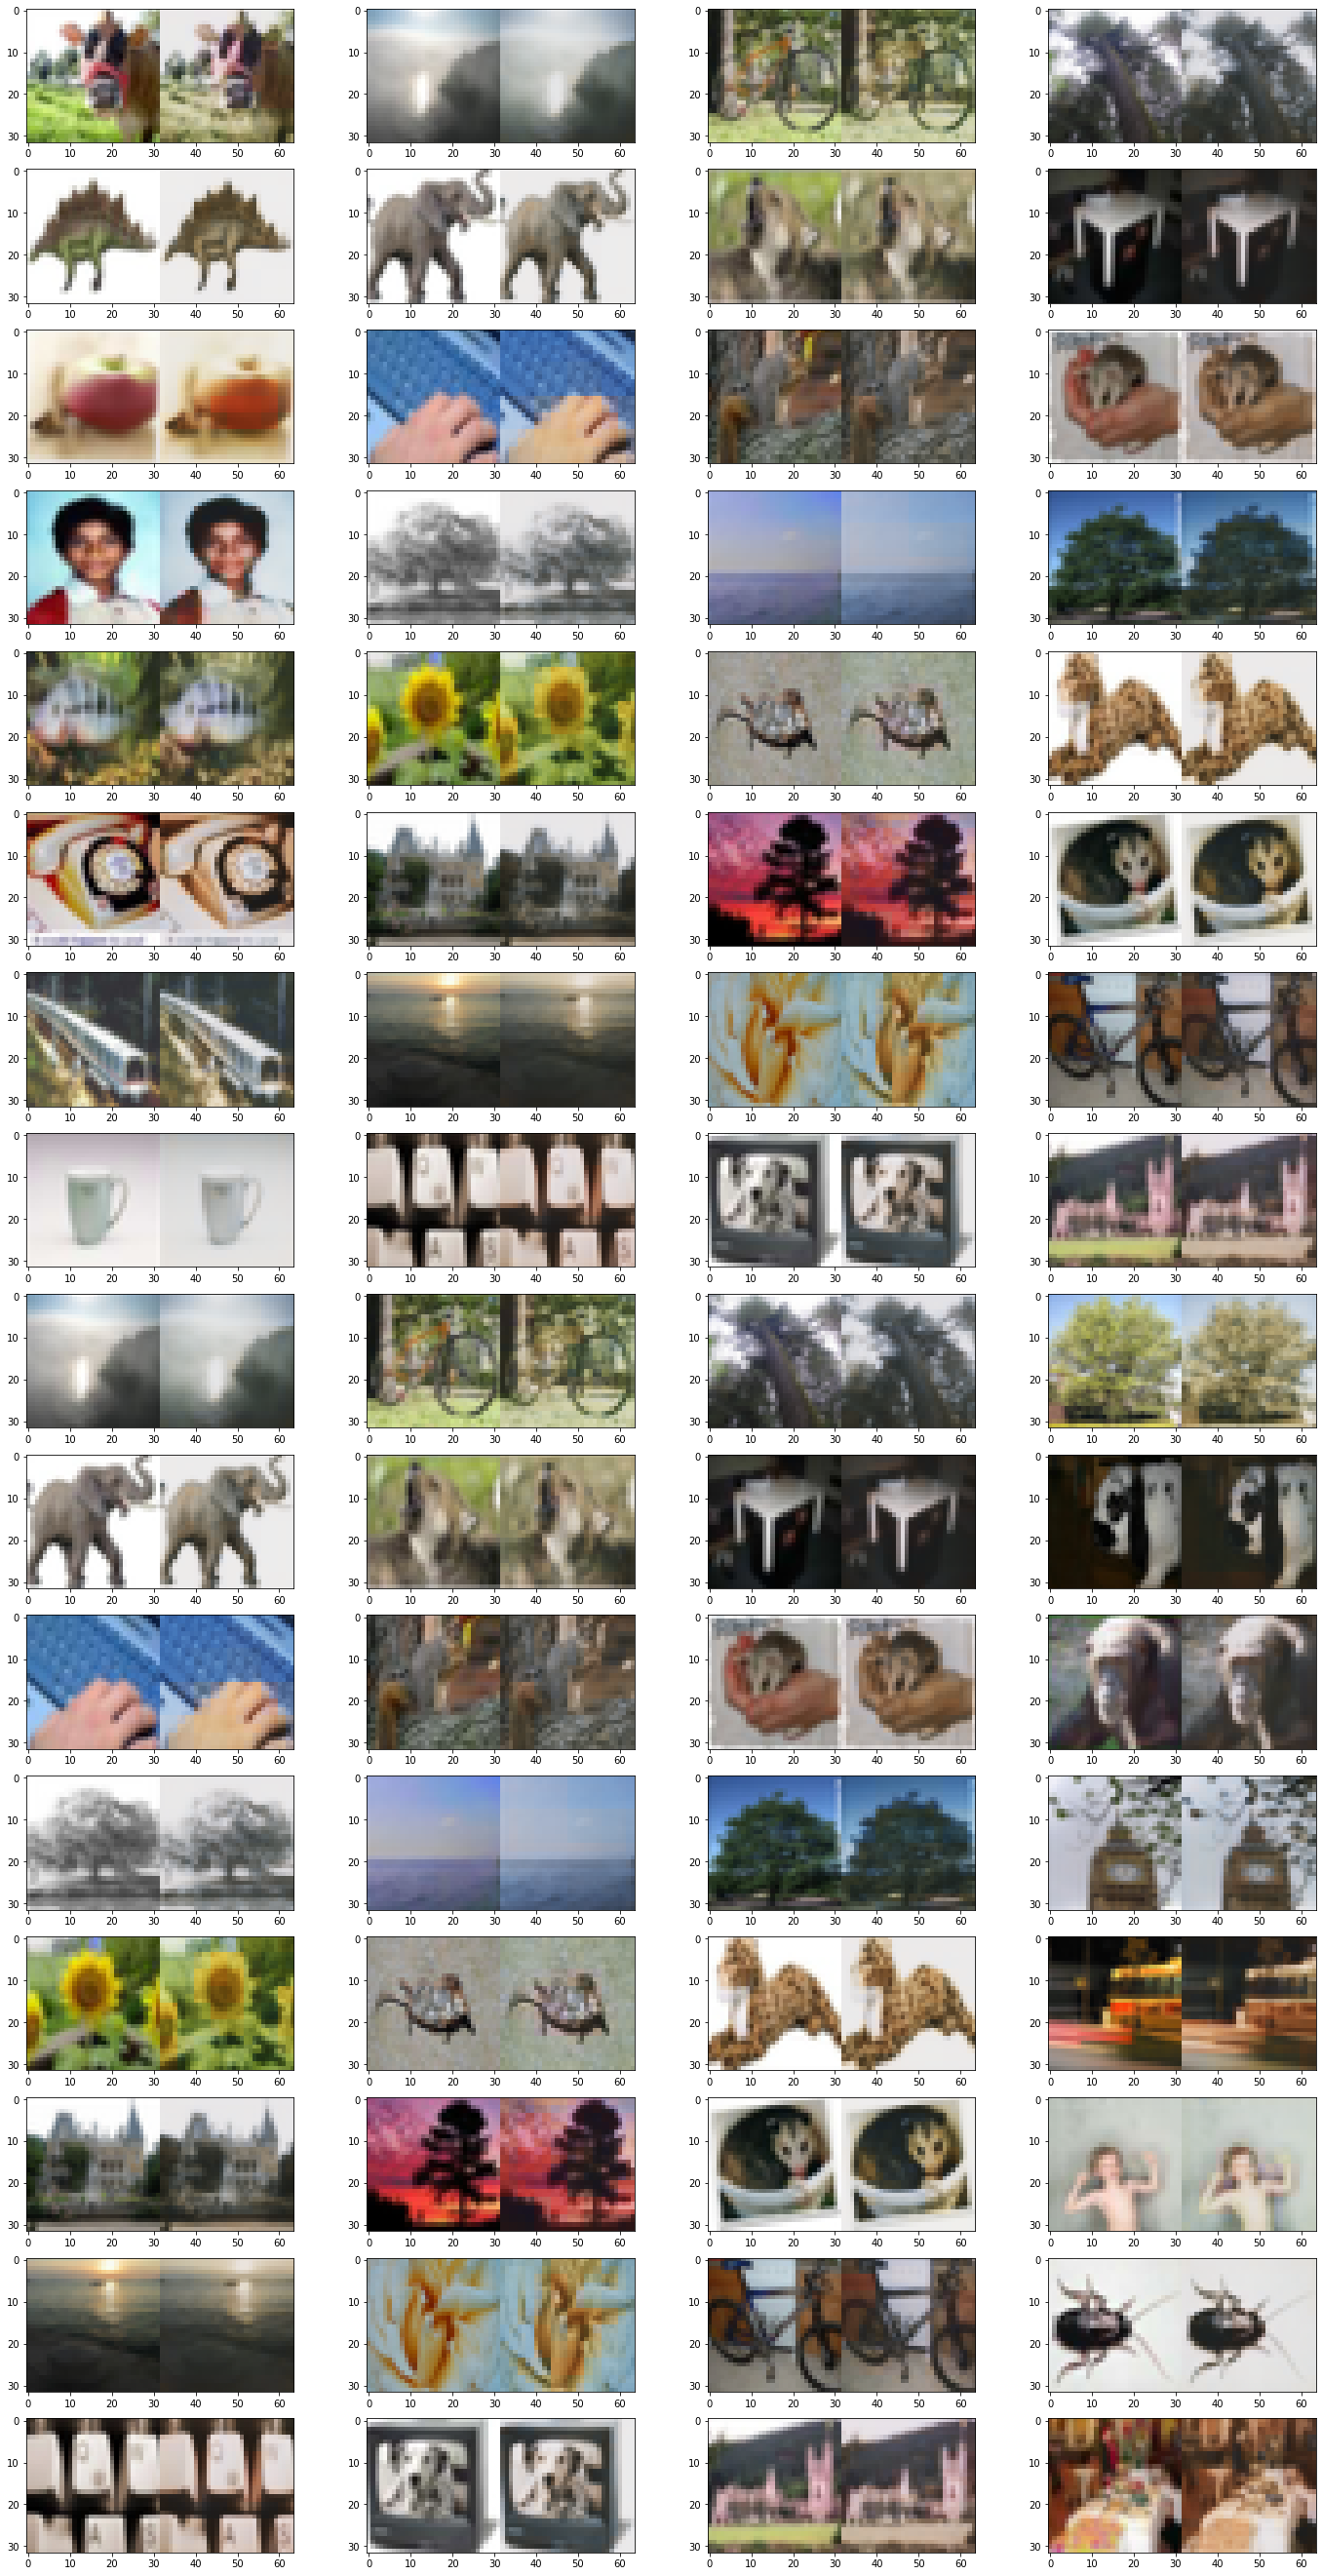

In [17]:
fig, axes = plt.subplots(16, 4, figsize = (24, 48))

for idx, row in enumerate(axes):
    for jdx, ax in enumerate(row):
        ax.imshow(img_arr[idx + 8 * jdx])


In [18]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 residual_layer (ResidualLay  (None, None, None, 3)    183       
 er)                                                             
                                                                 
 down_pooling_layer (DownPoo  (None, None, None, 6)    10        
 lingLayer)                                                      
                                                                 
 residual_layer_1 (ResidualL  (None, None, None, 6)    312       
 ayer)                                                           
                                                                 
 down_pooling_layer_1 (DownP  (None, None, None, 12)   10        
 oolingLayer)                                              

In [19]:
encoder.save('encoding_model')

In [20]:
!zip -r encoding_model.zip encoding_model

  adding: encoding_model/ (stored 0%)
  adding: encoding_model/variables/ (stored 0%)
  adding: encoding_model/variables/variables.index (deflated 80%)
  adding: encoding_model/variables/variables.data-00000-of-00001 (deflated 76%)
  adding: encoding_model/keras_metadata.pb (deflated 98%)
  adding: encoding_model/saved_model.pb (deflated 95%)
  adding: encoding_model/assets/ (stored 0%)


In [21]:
gcf.download('encoding_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>